In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm


# Train data analysis

In [101]:
train_data = dict()

envs = ['halfcheetah', 'hopper', 'walker2d']
datasets = ['expert', 'medium_replay', 'medium']

for e in envs:
    for d in datasets:
        with open(f'./data_plus_plus/{e}-{d}-v2.pkl', 'rb') as f:
            train_data[f'{e}-{d}'] = pickle.load(f)

In [102]:
# # for each dataset, combine all trajectories into a single long one
# def concatenate_dataset(dataset):
#     keys = list(dataset[0].keys())

#     total_dict = dict()
#     for key in keys:
#         total_dict[key] = dataset[0][key]

#     for traj in dataset[1:]:
#         for key in keys:
#             total_dict[key] = np.append(total_dict[key], traj[key], axis=0)
    
#     return total_dict

# concatenated_train_data = {k: concatenate_dataset(v) for k, v in tqdm(train_data.items())}


In [103]:
idxs = [f'{e}-{d}' for e in envs for d in datasets]
df_train_data = pd.DataFrame(index=idxs)

df_train_data['mean_terminals'] = [np.mean([sum(data['terminals']) for data in train_data[idx]]) for idx in idxs]
df_train_data['mean_total_reward'] = [np.mean([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['std_terminal_reward'] = [np.std([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['n_traj'] = [len(train_data[idx]) for idx in idxs]

,mean_terminals,mean_total_reward,std_terminal_reward,n_traj
halfcheetah-expert,0.000000,10656.426460,441.682728,1000
halfcheetah-medium_replay,0.000000,3093.285581,1680.693937,202
halfcheetah-medium,0.000000,4770.334765,355.750394,1000
hopper-expert,0.086660,3511.357707,328.585955,1027
hopper-medium_replay,0.803038,467.302044,511.025583,2041
hopper-medium,0.999543,1422.056180,378.953696,2186
walker2d-expert,0.001000,4920.507113,136.394925,1000
walker2d-medium_replay,0.723696,682.701247,895.955582,1093
walker2d-medium,0.431092,2852.088416,1095.443313,1190


In [104]:
from sklearn.linear_model import LinearRegression


def get_forward_reward(positions):
    return positions[1:] - positions[:-1]


def get_control_cost(actions):
    return np.sum(np.square(actions), axis=1)


# calculate the weights of the individual parts of the reward using linear regression
def get_coef(data_temp, use_healthy_reward=False):

    forward_reward = get_forward_reward(data_temp['infos/qpos'][:,0])
    ctrl_cost = get_control_cost(data_temp['actions'])

    target_reward = data_temp['rewards'][:-1]

    if use_healthy_reward:
        healthy_reward = np.array(~data_temp['terminals'], dtype=int)
        X = np.stack((forward_reward, ctrl_cost[:-1], healthy_reward[:-1]), axis=0).T
    else:
        X = np.stack((forward_reward, ctrl_cost[:-1]), axis=0).T

    reg = LinearRegression(fit_intercept=False).fit(X, target_reward)
    
    return reg, X, target_reward

# r_score = reg.score(X, target_reward)
# coef = reg.coef_ # forward_reward_weight, ctrl_cost_weight, (healthy_reward)
# predictions = reg.predict(X)

In [105]:
all_r_scores, all_coefs, all_traj_lens = [], [], []

for idx in idxs:
    trajs = train_data[idx]

    use_healthy_reward = idx.split('-')[0] != 'halfcheetah'

    r_scores, coefs, total_traj_len = [], [], 0
    for traj in trajs:
        
        traj_len = len(traj['rewards'])
        if 2 < traj_len: # dunno why 7 works but less doesn't
            reg, X, target_reward = get_coef(traj, use_healthy_reward=use_healthy_reward)

            total_traj_len += traj_len
            r_scores.append(traj_len * reg.score(X, target_reward))
            coefs.append(traj_len * reg.coef_)
    
    all_traj_lens.append(total_traj_len)
    all_r_scores.append(r_scores)
    all_coefs.append(coefs)

all_traj_lens = np.array(all_traj_lens)
df_train_data['r_scores'] = np.array([np.sum(arr) for arr in all_r_scores]) / all_traj_lens
df_train_data['coefs'] = [np.array(arr).sum(axis=0) / traj_len for arr, traj_len in zip(all_coefs, all_traj_lens)]



In [136]:
df_train_data['coefs'].to_list()

[array([20. , -0.1]),
 array([20. , -0.1]),
 array([20. , -0.1]),
 array([ 1.25017748e+02, -1.56608945e-03,  1.00007215e+00]),
 array([ 1.24981115e+02, -1.15143019e-03,  1.00002629e+00]),
 array([ 1.24958938e+02, -1.35067997e-03,  1.00021545e+00]),
 array([ 1.25059681e+02, -1.01284329e-03,  1.00026610e+00]),
 array([ 1.24693614e+02, -9.54932575e-04,  9.99491461e-01]),
 array([ 1.24829026e+02, -9.88069322e-04,  9.99778245e-01])]

# Do fit on right coefs

[ 1.25021335e+02 -1.59924108e-03  1.00001544e+00] 0.9999871383523756


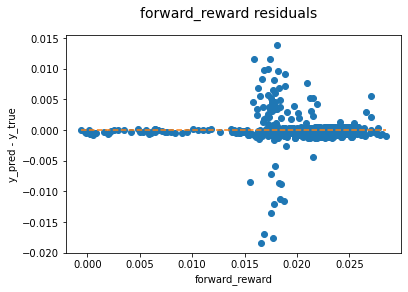

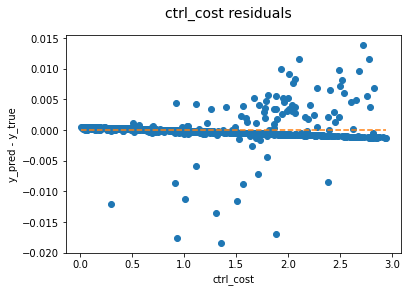

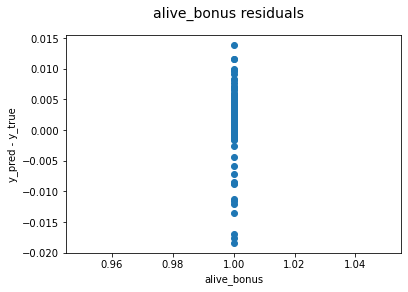

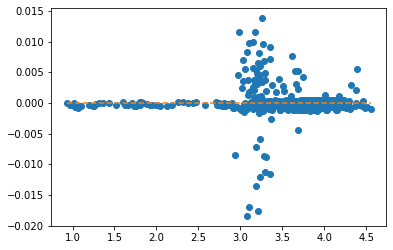

In [106]:
# half cheetah

# choose dataset
data_temp = train_data['hopper-expert'][0]
reg, X, target_reward = get_coef(data_temp, use_healthy_reward=True)
print(reg.coef_, reg.score(X, target_reward))

predictions = reg.predict(X)

names = ["forward_reward", "ctrl_cost", "alive_bonus"]
for i, (X_1dim, name) in enumerate(zip(X.T, names)):
    fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel("y_pred - y_true")
    plt.suptitle(f"{name} residuals", size=14)
    plt.scatter(X_1dim, predictions - target_reward, c='C0')
    plt.hlines(0, min(X_1dim), max(X_1dim), linestyles='--', colors='C1')
    plt.show()


plt.scatter(predictions, predictions - target_reward, c='C0')
plt.hlines(0, min(predictions), max(predictions), linestyles='--', colors='C1')
plt.show()

In [107]:
# # de to andre

# # choose dataset
# data_temp = train_data['walker2d-expert'][1]

# # get rewards
# forward_reward = get_forward_reward(data_temp['infos/qpos'][:,0])
# ctrl_cost = get_control_cost(data_temp['actions'])
# # healthy_reward = np.array(~data_temp['terminals'], dtype=int)
# target_reward = data_temp['rewards'][:-1]

# # define xs
# X = np.stack((forward_reward, ctrl_cost[:-1]), axis=0).T

# reg = LinearRegression().fit(X, target_reward)
# predictions = reg.predict(X)
# r_score = reg.score(X, target_reward)

# print(reg.coef_, r_score) # (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score

# plt.scatter(predictions, predictions - target_reward, c='C0')
# plt.hlines(0, min(predictions), max(predictions), linestyles='--', colors='C1')
# plt.xlabel("Prediction")
# plt.ylabel("Error")
# plt.title("Raw Trajectories")
# plt.show()


# # mask for points with low error
# tolerance = 0.002
# mask = abs(predictions - target_reward ) < tolerance

# X_masked = np.stack((forward_reward, ctrl_cost[:-1]), axis=0).T[mask]
# target_reward_masked = data_temp['rewards'][:-1][mask]

# reg = LinearRegression().fit(X_masked, target_reward_masked, healthy_reward[1:])
# predictions = reg.predict(X_masked)
# r_score = reg.score(X_masked, target_reward_masked)

# print(reg.coef_, r_score) # (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score

# plt.scatter(predictions, predictions - target_reward_masked, c='C0')
# plt.xlabel("Prediction")
# plt.ylabel("Error")
# plt.title("Removed data with error > 0.002")
# plt.hlines(0, min(predictions), max(predictions), linestyles='--', colors='C1')
# plt.show()

# Data dist plots

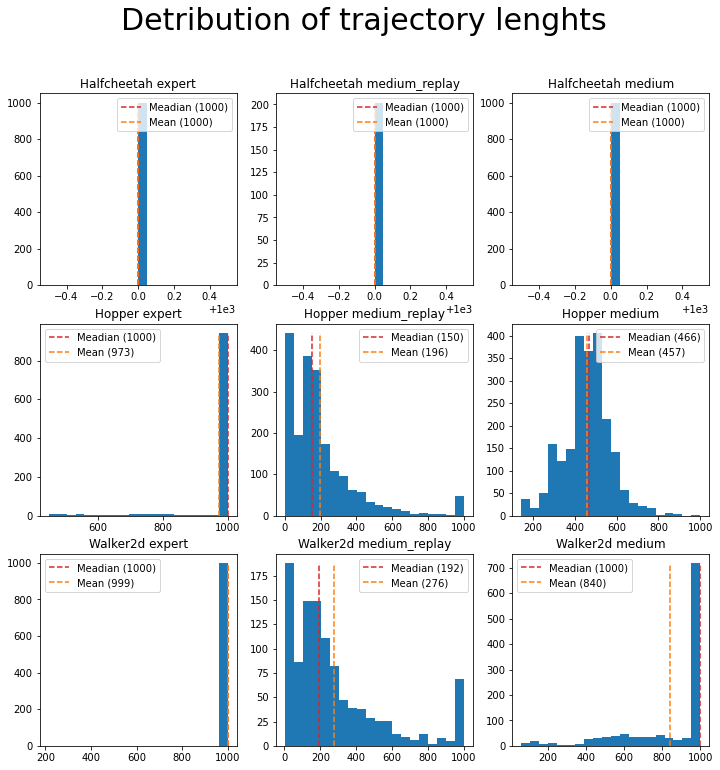

In [108]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12)) # note that halfcheetah does not terminate early, has no "survive" feature
fig.suptitle('Detribution of trajectory lenghts', size=30)

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    lengths = [len(data['rewards']) for data in train_data[key]]
    ax.set_title(f"{env.capitalize()} {dataset}")
    n, bins, _ = ax.hist(lengths, bins=20)

    median_val = np.median(lengths)
    ax.vlines(median_val, 0, max(n), linestyles='--', colors='C3', label=f'Meadian ({int(median_val)})')
    
    mean_val = np.mean(lengths)
    ax.vlines(mean_val, 0, max(n), linestyles='--', colors='C1', label=f'Mean ({int(mean_val)})')

    ax.legend()

plt.show()

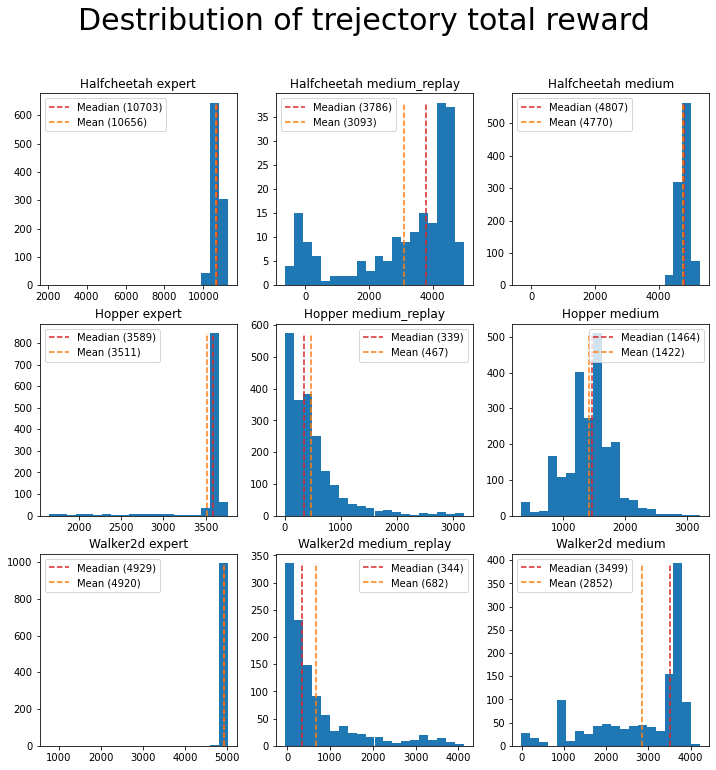

In [109]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Destribution of trejectory total reward', size=30)

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    terminal_rewards = [sum(data['rewards']) for data in train_data[key]]
    ax.set_title(f"{env.capitalize()} {dataset}")
    n, bins, _ = ax.hist(terminal_rewards, bins=20)

    median_val = np.median(terminal_rewards)
    ax.vlines(median_val, 0, max(n), linestyles='--', colors='C3', label=f'Meadian ({int(median_val)})')
    
    mean_val = np.mean(terminal_rewards)
    ax.vlines(mean_val, 0, max(n), linestyles='--', colors='C1', label=f'Mean ({int(mean_val)})')

    ax.legend()

plt.show()

# Evaluation analysis

In [114]:
eval_path = './evaluation_data/'
raw_eval_dict = dict()

for env in envs:

    eval_path_env = eval_path + env + '/'
    for dataset in datasets:
        
        eval_path_data = eval_path_env + dataset + '/'
        for filename in os.listdir(eval_path_data):
            with open(eval_path_data + filename, 'rb') as f:
                raw_eval_dict[filename] = pickle.load(f)

In [115]:
def read_data_to_DataFrama(raw_dict):

    return_keys = [key for key in raw_dict.keys() if '_returns' in key]
    temp_dict = dict()
    for key in return_keys:
        target_return, _ = key.split('_')
        target_return = float(target_return)
        temp_dict[target_return] = raw_dict[key]
    
    return pd.DataFrame(temp_dict)


def get_plot_statistics(df, conf_int=(0.05, 0.95)):

    target_rewards = df.columns.to_numpy()
    reward_mean = df.to_numpy().mean(axis=0)
    reward_median = np.quantile(df.to_numpy(), 0.5, axis=0)
    # reward_std = df.to_numpy().std(axis=0)
    q_low, q_high = np.quantile(df.to_numpy(), conf_int, axis=0)

    return target_rewards, reward_mean, reward_median, q_low, q_high


eval_dict = {k: read_data_to_DataFrama(v) for k, v in raw_eval_dict.items()}

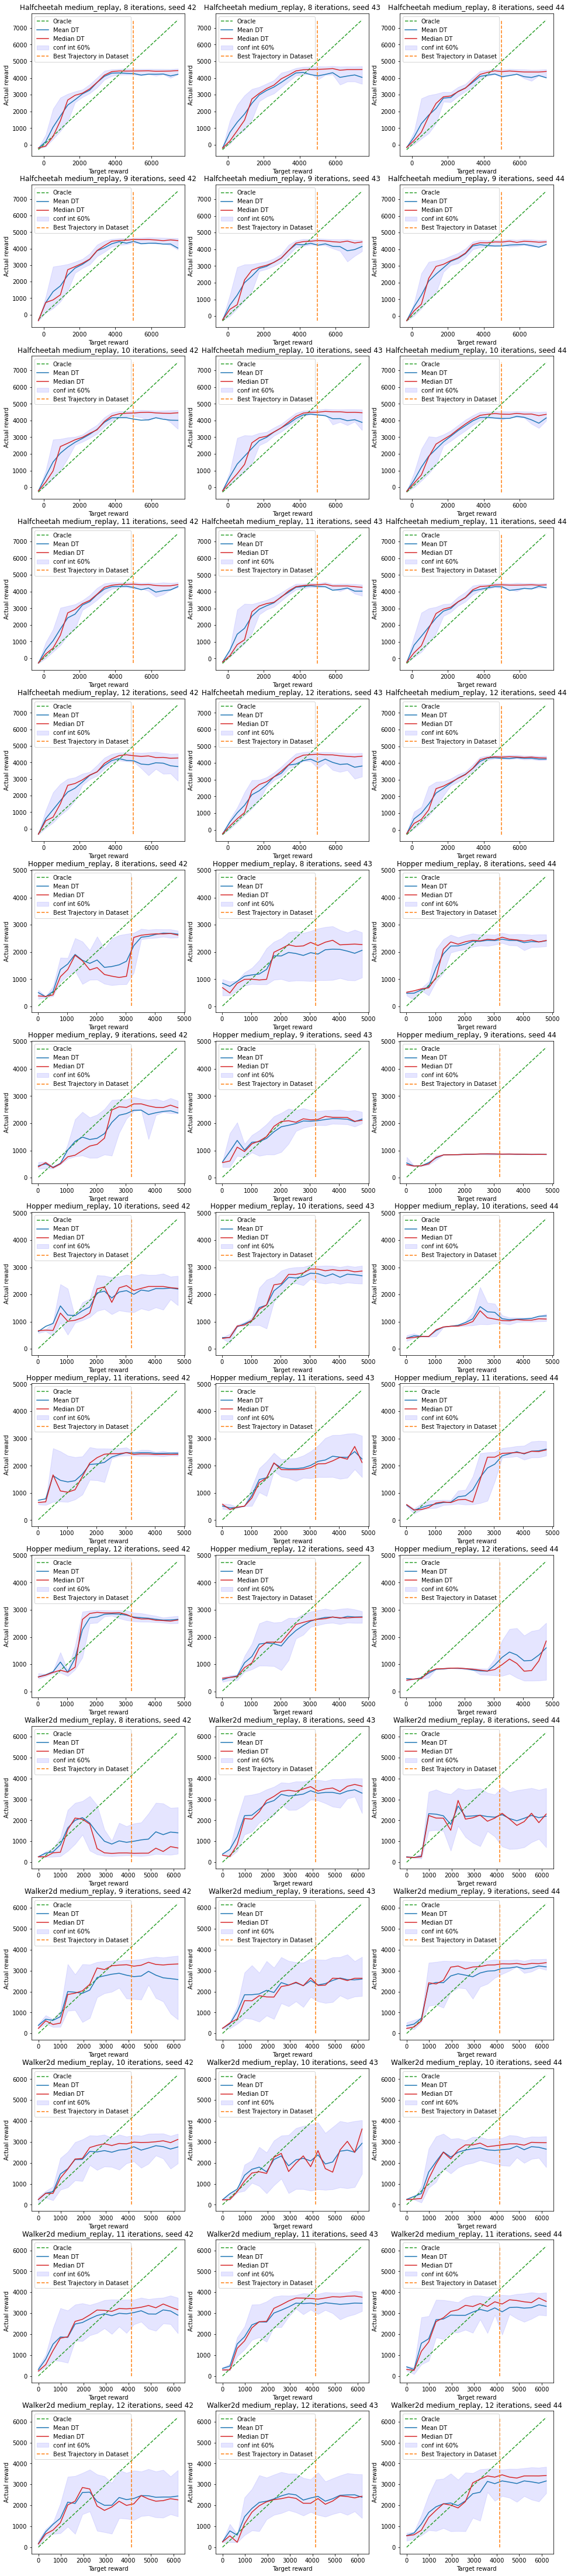

In [133]:
from itertools import product

seeds = range(42,45)
iters = range(8,13)
datasets = ['medium_replay']
env_names = ['halfcheetah', 'hopper', 'walker2d']
conf_int = (0.2, 0.8)

shape = (3,15) # set to none to calculate auto



filtered_keys = [f'iter{iter}-gym-experiment-{env}-{data}-{seed}' for env, data, iter, seed in product(env_names, datasets, iters, seeds)]

if shape is None:
    side_len = int(np.ceil(np.sqrt(len(filtered_keys))))
    shape = (side_len, side_len)

fig, axs = plt.subplots(shape[1], shape[0], figsize=(shape[0] * 16 / 3, shape[1] * 16 / 3))

for ax, exp_name in zip(axs.flatten(), filtered_keys):

    values = get_plot_statistics(eval_dict[exp_name], conf_int=conf_int)

    x, y_mean, y_median, q_low, q_high = values

    x_linear = np.linspace(min(x), max(x))
    ax.plot(x_linear, x_linear, '--', c='C2', label='Oracle')
    ax.plot(x, y_mean, c='C0', label='Mean DT')
    ax.plot(x, y_median, c='C3', label='Median DT')
    ax.fill_between(x, q_low, q_high, color='b', alpha=.1, label=f'conf int {int((conf_int[1]-conf_int[0])*100)}%')

    train_data_name = '-'.join(np.take(exp_name.split('-'), (3,4)))
    terminal_rewards = [sum(data['rewards']) for data in train_data[train_data_name]]
    ax.vlines(max(terminal_rewards), min(min(y_mean), min(x_linear)),
        max(max(y_mean), max(x_linear)), linestyles='--', colors='C1', label='Best Trajectory in Dataset')

    iter_name, _, _, env_name, data_name, seed = exp_name.split('-')
    ax.set_title(f"{env_name.capitalize()} {data_name}, {iter_name[4:]} iterations, seed {seed}" )
    ax.legend(loc="upper left")
    ax.set_xlabel('Target reward')
    ax.set_ylabel('Actual reward')

plt.show()
